# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Inference-problems-with-Poisson-distributed-gene-expression-data" data-toc-modified-id="Inference-problems-with-Poisson-distributed-gene-expression-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Inference problems with Poisson distributed gene expression data</a></div><div class="lev1 toc-item"><a href="#Inference-problems:-Poisson-mixtures" data-toc-modified-id="Inference-problems:-Poisson-mixtures-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Inference problems: Poisson mixtures</a></div><div class="lev2 toc-item"><a href="#The-right-way:-EM-algorithm-to-the-rescue." data-toc-modified-id="The-right-way:-EM-algorithm-to-the-rescue.-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>The right way: EM algorithm to the rescue.</a></div><div class="lev1 toc-item"><a href="#Cancer-vs-healthy" data-toc-modified-id="Cancer-vs-healthy-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Cancer vs healthy</a></div>

In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy.special import gammaln
from Bio import SeqIO

# Graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

# Magic function to make matplotlib inline;
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

# Inference problems with Poisson distributed gene expression data

In [2]:
def make_poisson(L):
    """generate a poisson random variable."""
    x = np.random.poisson(L, 500)
    if L < 10:
        sns.countplot(x, label='$\lambda=1$')
    else:
        sns.distplot(x)
    plt.xlabel('Number of observed events')
    plt.title('$\lambda = {0}$'.format(L))

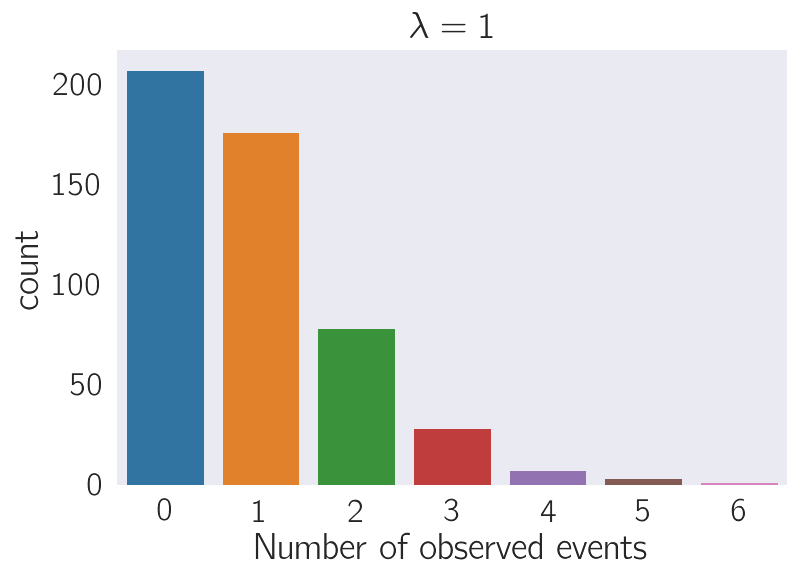

In [3]:
make_poisson(1)

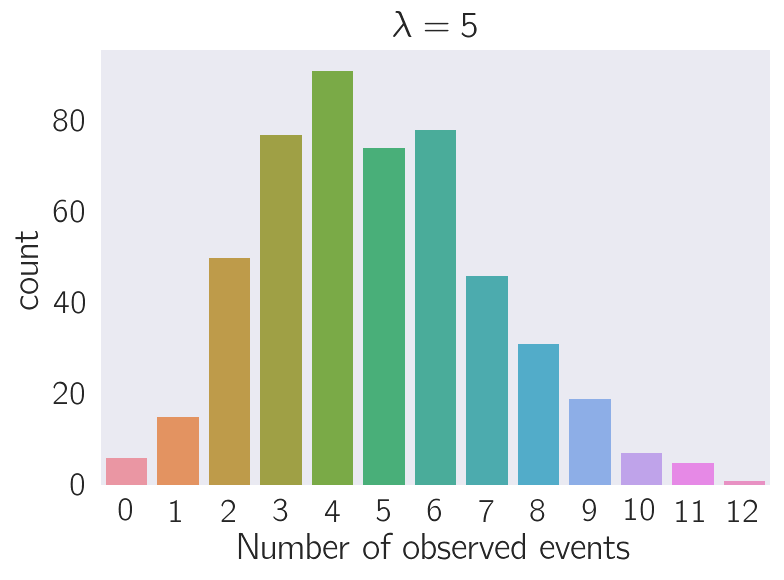

In [4]:
make_poisson(5)

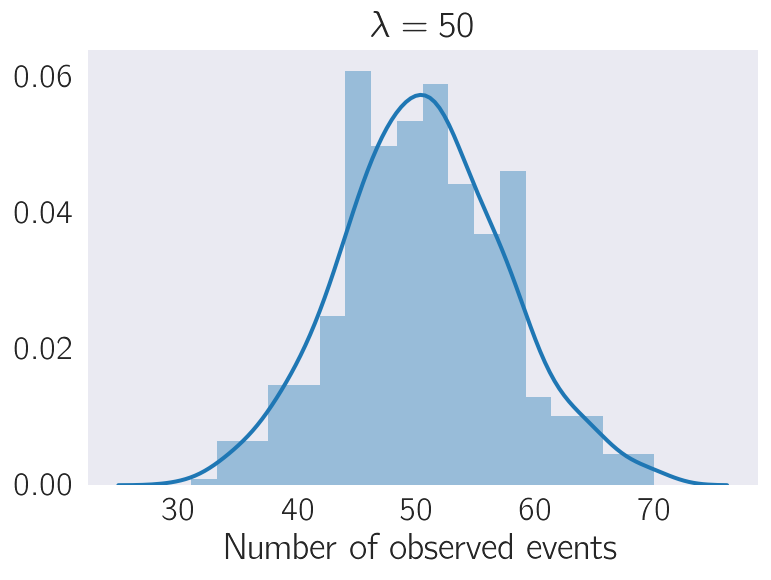

In [5]:
make_poisson(50)

In [6]:
def plot_mean_error(L, max_samples, ax):
    """Calculates and plots the error in the mean for samples containing 2 or more data points."""
    def mean_error(L, samples):
        """returns sqrt([L - L_est]**2)"""
        return [np.abs(np.mean(np.random.poisson(L, sample)) - L) for sample in samples]
    # plot:
    x = np.arange(2, max_samples)
    y = mean_error(L, x)
    ax.scatter(x, y, s=6, alpha=0.8)

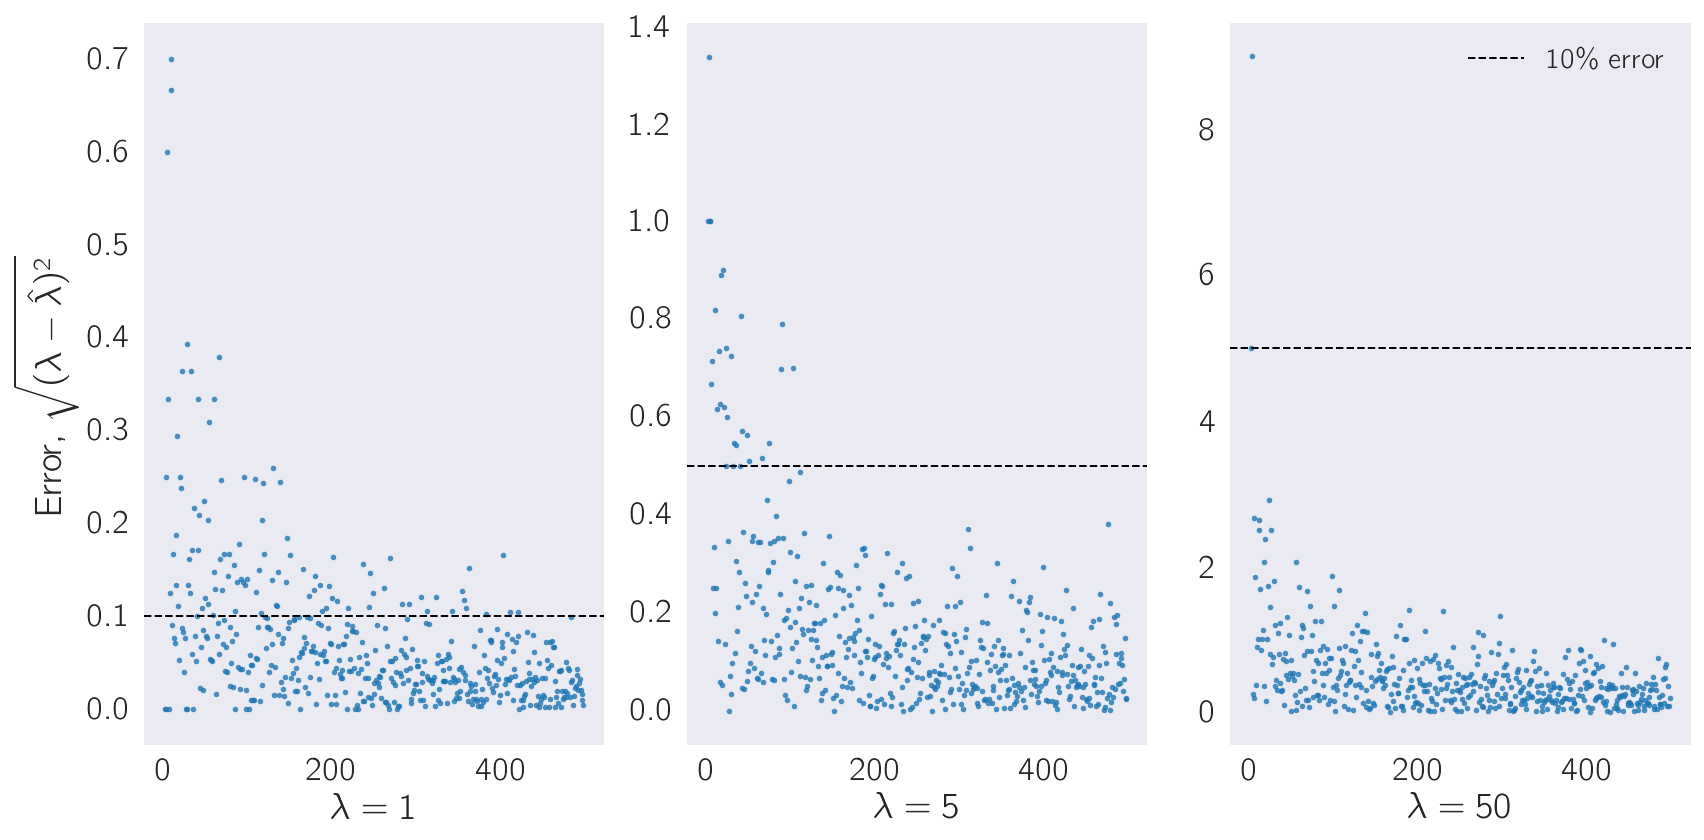

In [7]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 6))

L = [1, 5, 50]

plots = [None]*3
for i, l in enumerate(L):
    plot_mean_error(l, 500, ax[i])
    plots[i] = ax[i].axhline(l/10, ls='--', color='k', lw=1,
                             label='10\% error'.format(l))
    ax[i].set_xlabel('$\lambda = {0}$'.format(l))

plt.legend()
ax[0].set_ylabel('Error, $\sqrt{(\lambda - \hat{\lambda})^2}$')
plt.tight_layout()

When the firing/expression rate is low, we need many measurements to estimate $\lambda$ well (~100). By the time $\lambda > 10$, a couple of measurements are enough to begin to estimate the rate accurately.

# Inference problems: Poisson mixtures

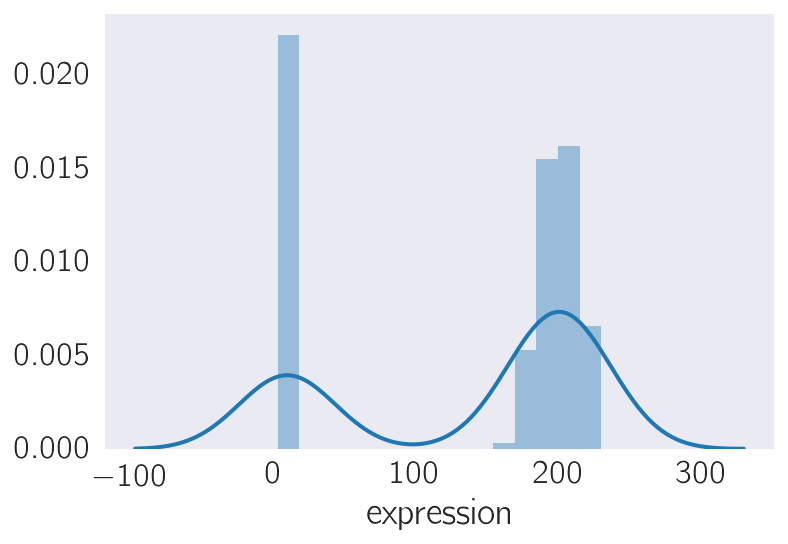

In [8]:
df1 = pd.read_csv('../input/brainmuscle1.csv', header=None)
df1.columns = ['expression']
sns.distplot(df1.expression, bins=15)

The dumb way to fit this dataset is to split it into two, then ML each subset individually. Let's try it.

In [9]:
# the lousy way: Split the data into two, fit each one individually
l1 = np.mean(df1[df1.expression < 100].expression.values)
l2 = np.mean(df1[df1.expression > 100].expression.values)
print("l1: {0:.2g}\nl2: {1:.2g}".format(l1, l2))

l1: 9.7
l2: 2e+02


Text(0.5,1,'EM works!!')

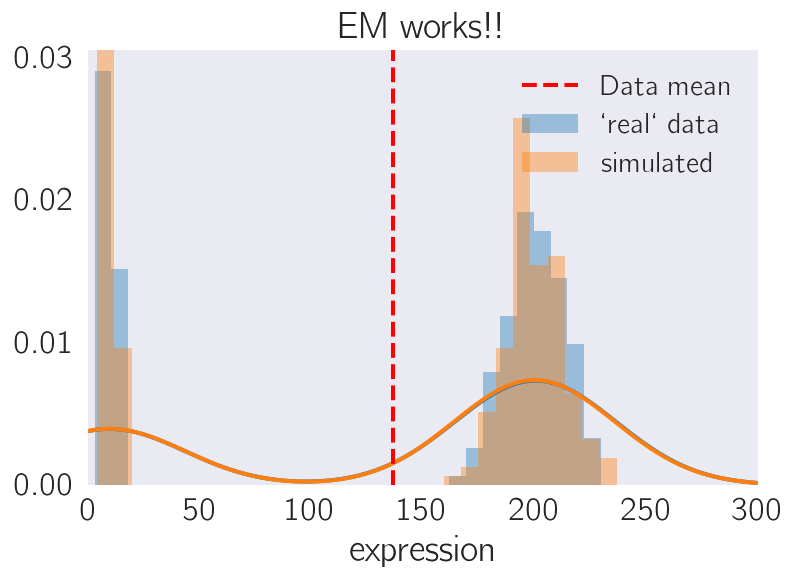

In [10]:
# simulate the dataset:
x1 = np.random.poisson(l1, np.sum(df1.expression.values < 100))
x2 = np.random.poisson(l2, np.sum(df1.expression.values > 100))

x = np.append(x1, x2)

sns.distplot(df1.expression, label='`real` data', bins=30)
sns.distplot(x, label='simulated', bins=30)
plt.axvline(df1.expression.mean(), label='Data mean',
            ls='--', color='red')
plt.xlim(0, 300)
plt.legend()
plt.title('EM works!!')

It works! But there's a better way to do this...

## The right way: EM algorithm to the rescue.

In [11]:
def ln_poisson(k, L):
    return k*np.log(L) - gammaln(k) - L

In [12]:
def M_step(p_z1J, X, L1, L2, t1):
    """
    Recalculate lambdas and mixings.
    """
    t2 = 1 - t1
    p_z2J = 1-p_z1J

    logL = np.sum(p_z1J*(np.log(t1)*ln_poisson(X, L1)))
    logL += np.sum(p_z2J*(np.log(t2)*ln_poisson(X, L2)))

    t1 = np.sum(p_z1J)/len(X)
    t2 = 1 - t1
    l1 = np.sum(p_z1J*X)/np.sum(p_z1J)
    l2 = np.sum(p_z2J*X)/np.sum(p_z2J)

    logL_after = np.sum(p_z1J*(np.log(t1)*ln_poisson(X, L1)))
    logL_after += np.sum(p_z2J*(np.log(t2)*ln_poisson(X, L2)))

    delta = np.abs(logL_after - logL)
    return t1, l1, l2, delta

def E_step(p_z1J, X, l1, l2, t1):
    """
    Recalculate weight probabilities.
    """
    t2 = 1 - t1

    def weight(x):
        Z = t1*np.exp(ln_poisson(x, l1)) + t2*np.exp(ln_poisson(x, l2))
        return t1*np.exp(ln_poisson(x, l1))/Z
    
    for i, x in enumerate(X):
        p_z1J[i] = weight(x)

    return p_z1J

In [13]:
# initialize parameters
X = df1.expression.values
p_z1J = X/np.max(X)
l1, l2 = 1, 300
t1 = 0.3
delta = 1

# run EM
while delta > 10**-6:
    p_z1j = E_step(p_z1J, X, l1, l2, t1)
    t1, l1, l2, delta = M_step(p_z1J, X, l1, l2, t1)
print("l1: {0:.2g}\nl2: {1:.2g}".format(l1, l2))

l1: 9.7
l2: 2e+02


We got exactly the same answer as before. Nice. Let's solve the second expression set.

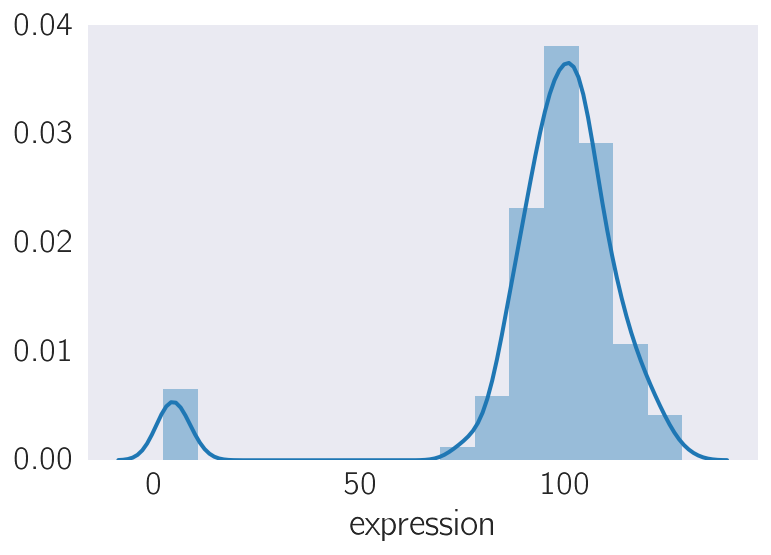

In [14]:
df2 = pd.read_csv('../input/brainmuscle2.csv', header=None)
df2.columns = ['expression']
sns.distplot(df2.expression, bins=15)

In [15]:
# initialize parameters
X = df2.expression.values
p_z1J = X/np.max(X)
l1, l2 = 1, 300
t1 = 0.3
delta = 1
# run EM
while delta > 10**-6:
    p_z1j = E_step(p_z1J, X, l1, l2, t1)
    t1, l1, l2, delta = M_step(p_z1J, X, l1, l2, t1)
print("l1: {0:.2g}\nl2: {1:.2g}".format(l1, l2))

l1: 4.6
l2: 1e+02


Text(0.5,1,'EM!')

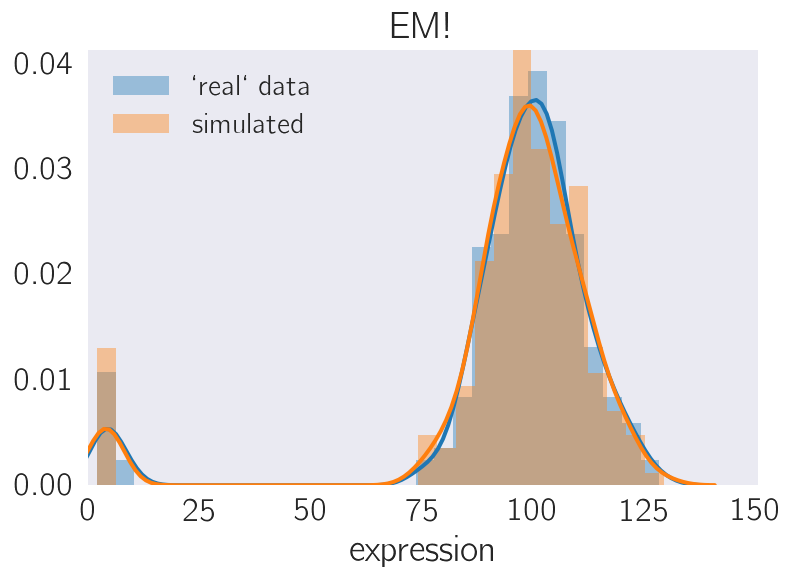

In [16]:
# simulate the dataset:
x1 = np.random.poisson(l1, np.sum(df2.expression.values < 50))
x2 = np.random.poisson(l2, np.sum(df2.expression.values > 50))

x = np.append(x1, x2)

sns.distplot(df2.expression, label='`real` data', bins=30)
sns.distplot(x, label='simulated', bins=30)
plt.xlim(0, 150)
plt.legend()
plt.title('EM!')

# Cancer vs healthy

In [17]:
h1 = pd.read_csv('../input/healthy1.csv', header=None)
h1.shape

(6232, 1985)

In [18]:
h1.head()

,0,1,2,3,4,5,6,7,8,9,...,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984
0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,240.73,0.00,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,516.0,0.0,0.0
1,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,...,0.0,414.77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1455.6,787.4,140.92,0.0,0.0,0.0,0.0,0.00,373.41,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# note: I am assuming each column is a cell...

Let's plot $\sigma$ vs $\mu$ for these healthy patients. 

Text(0,0.5,'$\\sigma$')

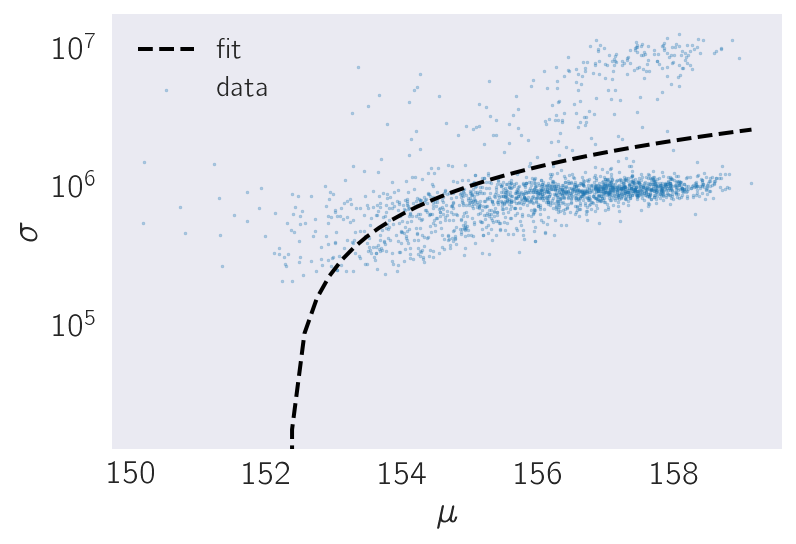

In [20]:
x, y = h1.mean(), h1.var()
X = np.linspace(np.min(x), np.max(x))
lr = scipy.stats.linregress(x, y)

plt.scatter(x, y, s=2, label='data', alpha=0.3)
plt.plot(X, lr.intercept + lr.slope*X,
         label='fit', lw=2, color='k', ls='--')
# plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('$\mu$')
plt.ylabel('$\sigma$')

print('y = {0:.2g} + {1:.2g}x'.format(lr.intercept, lr.slope))

Now let's plot $C_v$ vs $\mu$ for these healthy patients. 

Text(0,0.5,'$C_v$')

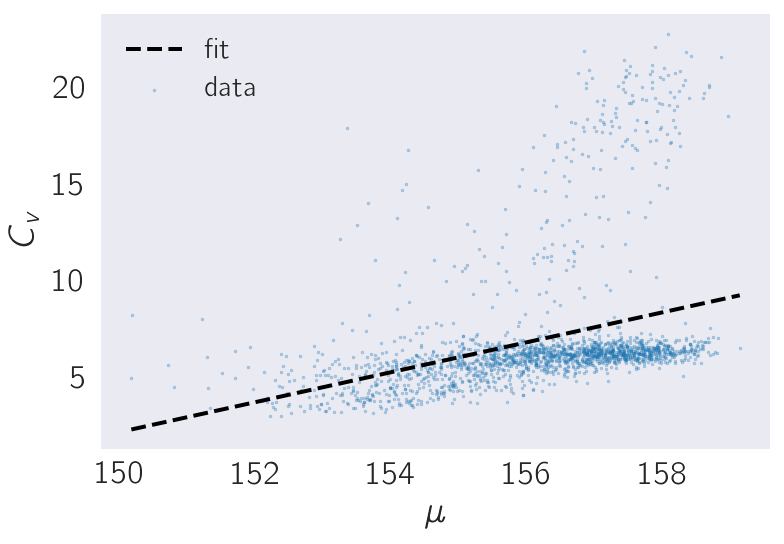

In [21]:
cv = h1.std()/x

lr = scipy.stats.linregress(x, cv)
plt.scatter(x, cv, s=2, label='data', alpha=0.3)
plt.plot(X, lr.intercept + lr.slope*X,
         label='fit', lw=2, color='k', ls='--')
plt.legend()
plt.xlabel('$\mu$')
plt.ylabel('$C_v$')
print('y = {0:.2g} + {1:.2g}x'.format(lr.intercept, lr.slope))

Next we are asked to make a histogram of zero count cells for each gene.

In [231]:
def count_zeros(df=h1):
    genes = (df.transpose() == 0)
    i = 0
    zero_counts = np.empty(len(genes.columns))
    for i, gene in enumerate(genes.columns):
        zero_counts[i] = np.sum(genes[gene])
    sns.distplot(zero_counts)
    plt.xlabel('Cells with zero counts of a gene, for all genes')
    plt.ylabel('Normalized frequency')
    return zero_counts/len(genes[gene])

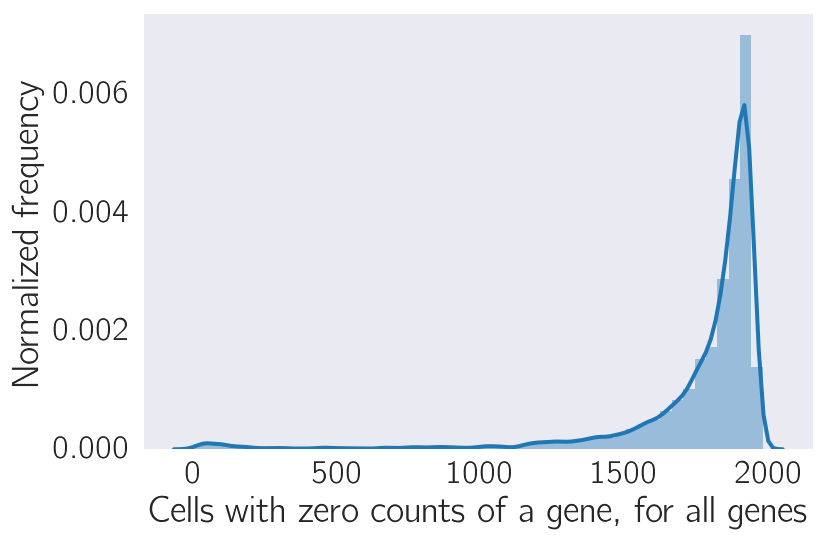

In [232]:
_ = count_zeros()

Let's fit a gamma distribution for the non-zero counts:

In [210]:
def gamma_inference(df=h1):
    genes = df.transpose()
    i = 0
    alpha = np.zeros(len(genes.columns))
    beta = np.zeros(len(genes.columns))
    for i, gene in enumerate(genes.columns):
        non_zero_counts = genes[gene][genes[gene] != 0].values

        if len(non_zero_counts) < 2:
            continue

        # estimate using method of moments
        # because scipy.stats.gamma is NOT the function I'm looking for
        # scipy.stats.gamma = x^(a+1)e^-x/beta; beta is only a scaling
        # factor.
        fit_beta = np.mean(non_zero_counts)/np.var(non_zero_counts)
        
        fit_alpha = np.mean(non_zero_counts)*fit_beta
        
        alpha[i] = fit_alpha
        beta[i] = fit_beta
    return alpha, beta

In [173]:
alpha, beta = gamma_inference()
x = np.matrix([alpha, beta])

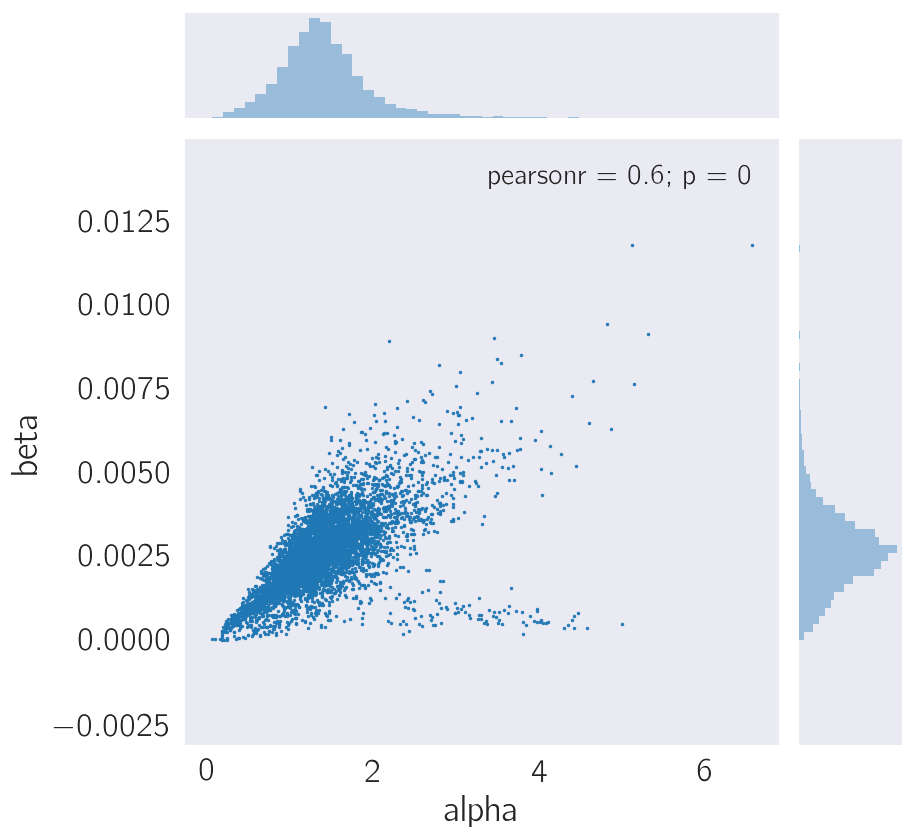

In [174]:
data = pd.DataFrame(x.transpose(), columns=['alpha', 'beta'])
sns.jointplot(x='alpha', y='beta', data=data, s=2)

And let's plot the data and overlay the fit on it to see how good it is.

In [218]:
def count_gene(gene, df=h1, real_label='scaled real data', sim_label='simulated data'):
    genes = df.transpose()
    alpha = np.zeros(len(genes.columns))
    beta = np.zeros(len(genes.columns))

    non_zero_counts = genes[gene][genes[gene] != 0].dropna().values
    if len(non_zero_counts) < 2:
        raise ValueError('Not enough observations')
    fit_beta = np.mean(non_zero_counts)/np.var(non_zero_counts)
    fit_alpha = np.mean(non_zero_counts)*fit_beta

    y = scipy.stats.gamma.rvs(fit_alpha, size=len(non_zero_counts))

    sns.distplot(non_zero_counts*fit_beta, label=real_label)
    sns.distplot(y, label=sim_label)
    plt.legend()
    
    plt.title('Overlay of scaled data with simulation from the fit gamma')
    plt.xlabel(r'$\frac{g_i}{\beta}$')
    plt.ylabel('Normalized frequency')

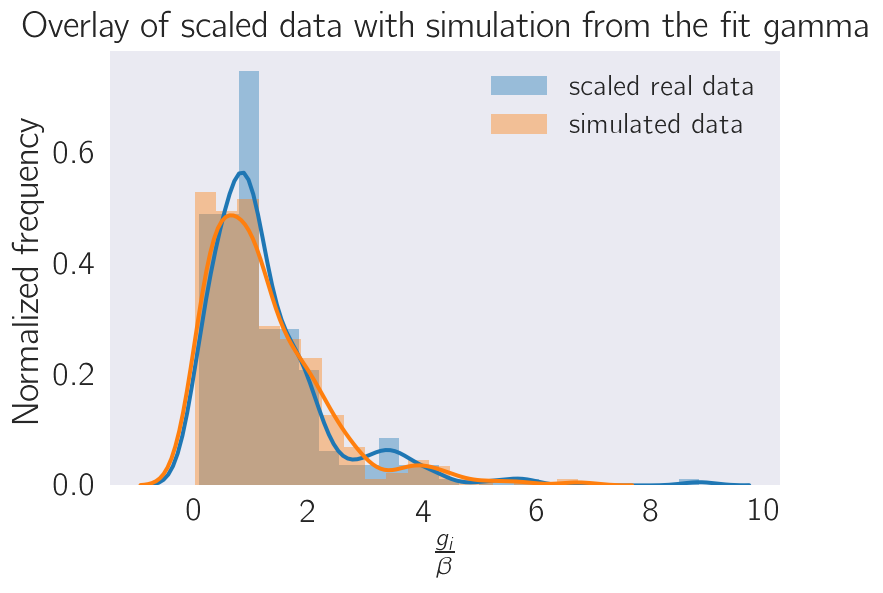

In [165]:
count_gene(1)

It works!

In [166]:
aml1 = pd.read_csv('../input/aml1.csv', header=None)
aml1.head()

,0,1,2,3,4,5,6,7,8,9,...,3923,3924,3925,3926,3927,3928,3929,3930,3931,3932
0,0.0,0.00,0.0,0.0,0.0,0.00,77.616,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000,0.0
1,0.0,0.00,0.0,0.0,0.0,570.13,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,86.14,0.0,0.000,0.0
2,0.0,0.00,0.0,0.0,0.0,0.00,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000,0.0
3,0.0,136.59,0.0,0.0,0.0,0.00,232.850,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,82.706,0.0
4,0.0,0.00,0.0,0.0,0.0,0.00,77.616,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000,0.0


In [183]:
aml1.head()

,0,1,2,3,4,5,6,7,8,9,...,3923,3924,3925,3926,3927,3928,3929,3930,3931,3932
0,0.0,0.00,0.0,0.0,0.0,0.00,77.616,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000,0.0
1,0.0,0.00,0.0,0.0,0.0,570.13,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,86.14,0.0,0.000,0.0
2,0.0,0.00,0.0,0.0,0.0,0.00,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000,0.0
3,0.0,136.59,0.0,0.0,0.0,0.00,232.850,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,82.706,0.0
4,0.0,0.00,0.0,0.0,0.0,0.00,77.616,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000,0.0


In [188]:
alpha_aml1, beta_aml1 = gamma_inference(aml1)
x = np.matrix([alpha_aml1, beta_aml1])

data_aml1 = pd.DataFrame(x.transpose(), columns=['alpha', 'beta'])

Text(0,0.5,'$\\beta$')

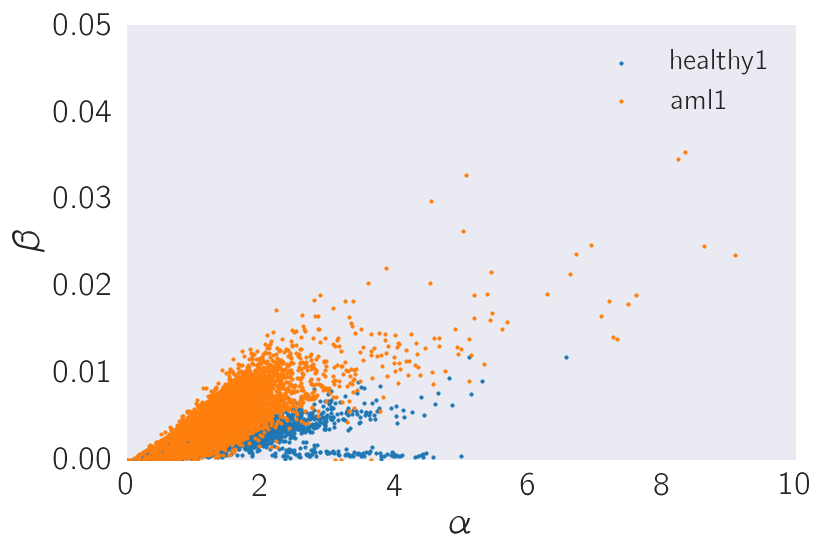

In [202]:
plt.scatter(alpha, beta, label='healthy1', s=3)
plt.scatter(alpha_aml1, beta_aml1, label='aml1', s=3)

plt.legend()

plt.xlim(0, 10)
plt.ylim(0, .05)

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')

Next, we are asked to find a coordinate pair that is different between the healthy and AML samples. However, I am way too lazy to implement the second derivative method to find confidence intervals, so in the hack below I've simply found the gene with the largest manhattan distance between the healthy and control samples.

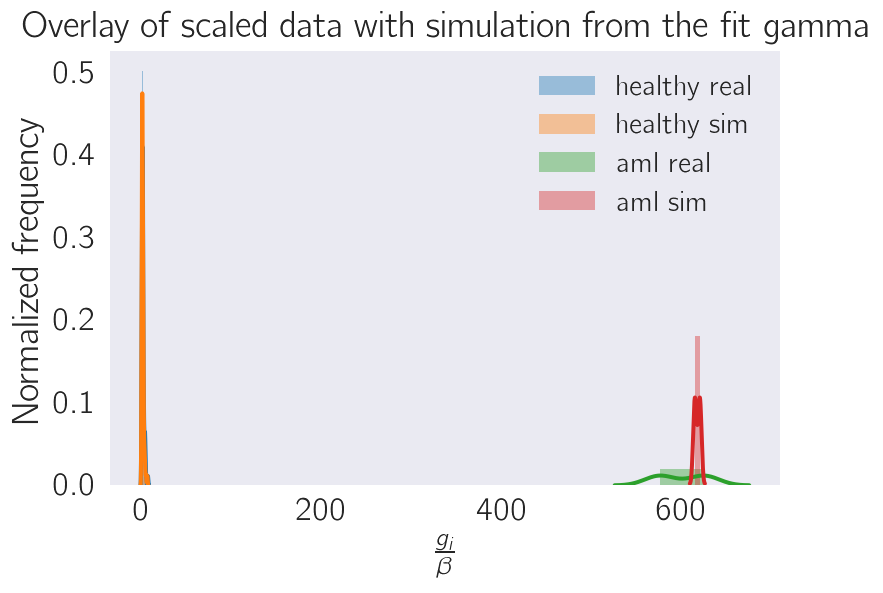

In [220]:
gene = np.where((alpha - alpha_aml1)**2 + (beta - beta_aml1)**2 == np.max((alpha - alpha_aml1)**2 + (beta - beta_aml1)**2))
count_gene(gene[0], real_label='healthy real', sim_label='healthy sim')
count_gene(gene[0], df=aml1, real_label='aml real', sim_label='aml sim')

In [247]:
def gamma(x, a, b):
    return b**a/scipy.special.gamma(a)*np.exp(-b*x)

def mixed_gamma_zero_prob(x, alpha, beta, w):
    return w*(x == 0) + (1-w)*gamma(x, alpha, beta)

def odds(h, aml, params1, params2):
    alpha1, beta1, w1 = params1
    alpha2, beta2, w2 = params2
    return np.log(mixed_gamma_zero_prob(h, alpha1, beta1, w1)) - np.log(mixed_gamma_zero_prob(aml, alpha2, beta2, w2)) 

In [227]:
h2 = pd.read_csv('../input/healthy2.csv')
aml2 = pd.read_csv('../input/aml2.csv')

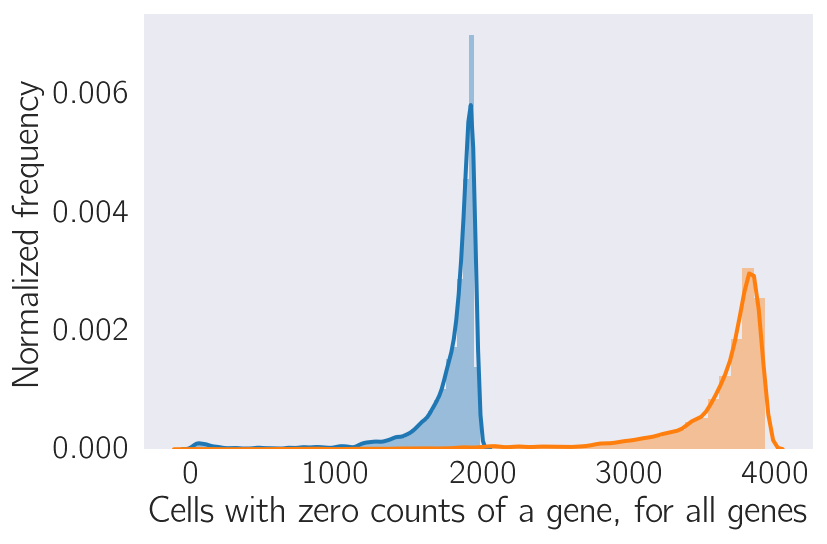

In [233]:
w_healthy = count_zeros()
w_aml = count_zeros(aml1)

Ran out of time here. Sorry!

In [248]:
params1 = w_healthy[0], alpha[0], beta[0]
params2 = w_aml[0], alpha_aml1[0], beta_aml1[0]

odds(h2.as_matrix()[0][0], aml2.as_matrix()[0][0], params1, params2)

0.02886623297258256

In [289]:
def shuffle(df):
    return df.reindex(np.random.permutation(df.index))

def odds_for_cell(cell, h, a):
#     h = shuffle(h)
#     a = shuffle(a)
    
    logL = 0
    for i, h in enumerate(h[cell].values):
        uh = a[cell].values[i]
        params1 = w_healthy[gene], alpha[gene], beta[gene]
        params2 = w_aml[gene], alpha_aml1[gene], beta_aml1[gene]
        logL += odds(h, uh, params1, params2)
    return logL